# 1. 加载数据

In [61]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import os
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

# 设置 Matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimSong']
plt.rcParams['axes.unicode_minus'] = False

# 加载数据
columns_to_load = ['地区', '类型', '面积(㎡)', '单价(元/㎡)', '租金单价(元/㎡/月)']
df = pd.read_parquet('../Data/cleaned_full_data.parquet', columns=columns_to_load)
df


,地区,类型,面积(㎡),单价(元/㎡),租金单价(元/㎡/月)
0,Zhongxin,esf,275.10,16357.0,NaN
1,Zhongxin,esf,87.00,6896.0,NaN
2,Zhongxin,esf,132.64,27895.0,NaN
3,Zhongxin,esf,275.00,13454.0,NaN
4,Zhongxin,esf,247.00,22550.0,NaN
...,...,...,...,...,...
8976,Zhongxin,zu,83.00,NaN,31.325301
8977,Zhongxin,zu,95.00,NaN,25.263158
8978,Zhongxin,zu,104.00,NaN,25.961538
8979,Zhongxin,zu,93.00,NaN,21.505376


# 2. 对单价和租金单价分别建立回归模型

对于回归方程
$$price = \alpha_0\cdot area +\sum \gamma_j\cdot location_j+\varepsilon_j$$
$$rent = \alpha_0\cdot area+\sum \gamma_j\cdot location_j+\varepsilon_j$$
首先，筛选出二手房的数据，再将地区转化为虚拟变量

In [62]:
df_esf = df[df['类型'] == 'esf'].copy()

region_dummies = pd.get_dummies(df_esf['地区'], prefix='地区', dtype=int)
df_multi_regr = pd.concat([df_esf, region_dummies], axis=1)

y_price = df_esf['单价(元/㎡)']

# X包含面积和所有的地区虚拟变量
X_price = pd.concat([df_esf['面积(㎡)'], region_dummies], axis=1)

# 建立并拟合模型
model_price_no_baseline = sm.OLS(y_price, X_price).fit()

# 打印回归结果
print(model_price_no_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:                单价(元/㎡)   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     1995.
Date:                Sun, 12 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:27:15   Log-Likelihood:                -51966.
No. Observations:                4800   AIC:                         1.039e+05
Df Residuals:                    4795   BIC:                         1.040e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
面积(㎡)             11.4357      3.362      3.

对于租房数据，操作同上

In [63]:
df_zu = df[df['类型'] == 'zu'].copy()

region_dummies = pd.get_dummies(df_zu['地区'], prefix='地区', dtype=int)
df_multi_regr = pd.concat([df_zu, region_dummies], axis=1)

y_price = df_zu['租金单价(元/㎡/月)']

# X包含面积和所有的地区虚拟变量
X_price = pd.concat([df_zu['面积(㎡)'], region_dummies], axis=1)

# 建立并拟合模型
model_rent_no_baseline = sm.OLS(y_price, X_price).fit()

# 打印回归结果
print(model_rent_no_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:            租金单价(元/㎡/月)   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     1277.
Date:                Sun, 12 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:27:15   Log-Likelihood:                -18267.
No. Observations:                4181   AIC:                         3.654e+04
Df Residuals:                    4176   BIC:                         3.658e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
面积(㎡)             -0.0206      0.006     -3.

In [64]:
stargazer = Stargazer([model_price_no_baseline, model_rent_no_baseline])

# 自定义表格标题和变量名
stargazer.title('二手房与租金回归模型对比')
stargazer.custom_columns(['二手房单价模型', '租金单价模型'], [1, 1]) # 为模型命名
stargazer.rename_covariates({
    '面积(㎡)': '面积',
    '地区_Balitai': '地区: 八里台',
    '地区_Quanyechang': '地区: 劝业场',
    '地区_Wuqing': '地区: 武清',
    '地区_Zhongxin': '地区: 中新生态城'
})

# 生成HTML格式的表格，并在Jupyter中显示
HTML(stargazer.render_html())

# 3. 交叉预测

首先，创建一个完整的，含有虚拟变量的 df 用于后续预测

In [65]:
full_region_dummies = pd.get_dummies(df['地区'], prefix='地区', dtype=int)
X_full = pd.concat([df['面积(㎡)'], full_region_dummies], axis=1)
X_full

,面积(㎡),地区_Balitai,地区_Quanyechang,地区_Wuqing,地区_Zhongxin
0,275.10,0,0,0,1
1,87.00,0,0,0,1
2,132.64,0,0,0,1
3,275.00,0,0,0,1
4,247.00,0,0,0,1
...,...,...,...,...,...
8976,83.00,0,0,0,1
8977,95.00,0,0,0,1
8978,104.00,0,0,0,1
8979,93.00,0,0,0,1


In [66]:
df['预测_售价单价(元/㎡)'] = model_price_no_baseline.predict(X_full)
df['预测_租金单价(元/㎡/月)'] = model_rent_no_baseline.predict(X_full)
display(df)

data_path = '../Data/'
output_filename = 'OLS_predicted_data.parquet'
output_path = os.path.join(data_path, output_filename)
df.to_parquet(output_path, index=False, engine='pyarrow')

,地区,类型,面积(㎡),单价(元/㎡),租金单价(元/㎡/月),预测_售价单价(元/㎡),预测_租金单价(元/㎡/月)
0,Zhongxin,esf,275.10,16357.0,NaN,15797.415802,21.220712
1,Zhongxin,esf,87.00,6896.0,NaN,13646.367801,25.103645
2,Zhongxin,esf,132.64,27895.0,NaN,14168.291409,24.161502
3,Zhongxin,esf,275.00,13454.0,NaN,15796.272236,21.222777
4,Zhongxin,esf,247.00,22550.0,NaN,15476.073703,21.800778
...,...,...,...,...,...,...,...
8976,Zhongxin,zu,83.00,NaN,31.325301,13600.625153,25.186216
8977,Zhongxin,zu,95.00,NaN,25.263158,13737.853096,24.938501
8978,Zhongxin,zu,104.00,NaN,25.961538,13840.774053,24.752715
8979,Zhongxin,zu,93.00,NaN,21.505376,13714.981772,24.979787


# 4. 计算预测租售比
接下来根据预测的数据计算中位数并且计算租售比，画出条形图

In [67]:
# 按地区分组，分别计算预测单价的中位数和预测租金的中位数
pre_median_prices = df[df['类型'] == 'esf'].groupby('地区')['预测_售价单价(元/㎡)'].median()
pre_median_rents = df[df['类型'] == 'zu'].groupby('地区')['预测_租金单价(元/㎡/月)'].median()

# 合并成一个新的DataFrame
ratio_df = pd.DataFrame({
    '二手房预测单价中位数(元/㎡)': pre_median_prices,
    '月租金预测单价中位数(元/㎡/月)': pre_median_rents
})

ratio_df['预测租售比'] = ratio_df['二手房预测单价中位数(元/㎡)'] / ratio_df['月租金预测单价中位数(元/㎡/月)']
display(ratio_df.sort_values('预测租售比', ascending=True))

,二手房预测单价中位数(元/㎡),月租金预测单价中位数(元/㎡/月),预测租售比
地区,,,
Zhongxin,14090.128660,25.041716,562.666263
Balitai,29406.203739,46.745553,629.069546
Wuqing,12363.181748,16.474500,750.443541
Quanyechang,51490.881495,68.223861,754.734209


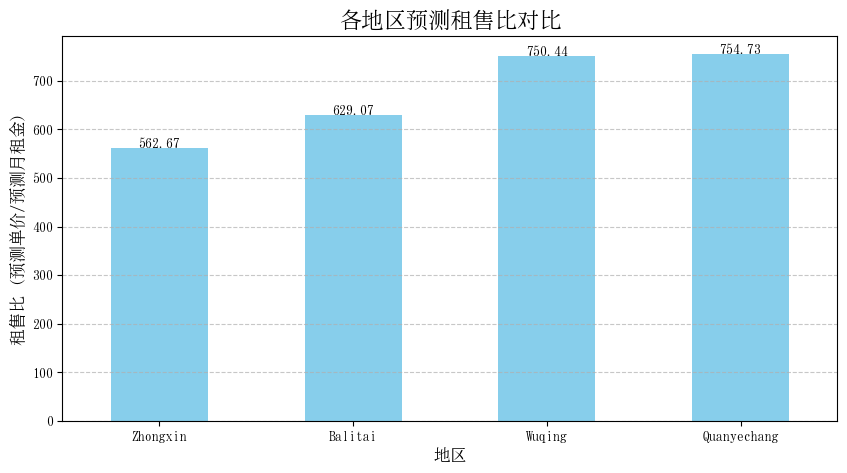

In [68]:
# --- 可视化租售比 ---
plt.figure(figsize=(10, 5))
ax = ratio_df['预测租售比'].sort_values().plot(kind='bar', color='skyblue')
ax.set_title('各地区预测租售比对比', fontsize=16)
ax.set_ylabel('租售比 (预测单价/预测月租金)', fontsize=12)
ax.set_xlabel('地区', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 在每个柱子上方添加数值标签
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + 0.05,
            f'{height:.2f}',
            ha='center'
        )

# 定义保存的文件夹和文件名
figure_dir = '../figure_results'
file_name = 'FigureB.png'
output_path = os.path.join(figure_dir, file_name)

# 确保文件夹存在，如果不存在则创建它
os.makedirs(figure_dir, exist_ok=True)

# 保存图表
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()